In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from math import sqrt

from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import GlobalMaxPooling1D
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
train = pd.read_csv('csv/train.csv')
valid = pd.read_csv("csv/test.csv")

In [3]:
train.head()

,title,description,plot,csm_review,need_to_know,par_rating,kids_rating,csm_rating,Author,Genre,...,Publisher's recommended age(s),Number of pages,Available on,Last updated,Illustrator,Authors,Awards,Publishers,Award,Illustrators
0,"Carly Keene, Literary Detective: Braving the B...",Mysterious time-travel story for adventurous b...,CARLY KEENE LITERARY DETECTIVE: BRAVING THE BR...,Carly Keene Literary Detective: Braving the Br...,Parents need to know that Katherine Rue's Carl...,NaN,NaN,10,Katherine Rue,Historical Fiction,...,NaN,262.0,"Paperback, Kindle","June 19, 2019",Nick Guarracino,NaN,NaN,NaN,NaN,NaN
1,Tangerine,"A complex tale about teens, family relationships.","Paul Fisher can see things his parents can't, ...","This complex, multilayered novel is impossible...",Parents need to know that the contrasting brot...,12.0,11.0,11,Edward Bloor,Coming of Age,...,NaN,294.0,NaN,"July 06, 2016",NaN,NaN,NaN,NaN,NaN,NaN
2,One Boy,"Counting and wordplay, with eye-catching color...","One boy sits alone in the beginning, starting ...","From the dye-cut red cover to the final page, ...",Parents need to know that nearly every book La...,17.0,NaN,3,Laura Vaccaro Seeger,Picture Book,...,2 - 6,48.0,NaN,"July 13, 2017",Laura Vaccaro Seeger,NaN,NaN,NaN,NaN,NaN
3,"Lu: Track, Book 4",Heartfelt ending to award-winning series on sp...,"In LU: TRACK, BOOK 4, Lu has swagger. He's a r...",Author Jason Reynolds wraps up an outstanding ...,Parents meed to know that Lu: Track Book 4 is ...,NaN,NaN,10,Jason Reynolds,Sports,...,10 - 17,224.0,"Nook, Hardback, iBooks, Kindle","April 15, 2019",NaN,NaN,NaN,NaN,NaN,NaN
4,Emma,"Austen's romantic, comic classic has timeless ...",Jane Austen's classic novel EMMA begins with t...,"Funny and highly entertaining, Emma is full of...",Parents need to know that Jane Austen's belove...,NaN,14.0,13,Jane Austen,Romance,...,NaN,544.0,"Paperback, Nook, Audiobook (unabridged), Hardb...","February 24, 2020",NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train.loc[1, "description"]

'A complex tale about teens, family relationships.'

## Create the splits

In [5]:
x_tr, y_tr = train['description'].values, train['csm_rating'].values
x_val, y_val = valid["description"].values, valid["csm_rating"].values

In [6]:
print(x_tr.shape, y_tr.shape)

(4651,) (4651,)


In [7]:
print(x_val.shape, y_val.shape)

(1164,) (1164,)


## Prepare the Data

In [8]:
#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(x_tr))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(x_tr) 
x_val_seq = tokenizer.texts_to_sequences(x_val)

print(len(max(x_tr_seq, key=len)))
print(len(min(x_tr_seq, key=len)))

14
4


In [9]:
#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=14)
x_val_seq = pad_sequences(x_val_seq, maxlen=14)
print(len(max(x_tr_seq, key=len)))
print(len(min(x_tr_seq, key=len)))

14
14


In [10]:
x_tr_seq[1]

array([   0,    0,    0,    0,    0,    0,    0,    5,  114,    3,   15,
         29,   33, 1039], dtype=int32)

In [11]:
max_length = len(max(x_tr_seq, key=len))

In [12]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

5799


## Create embeddings

In [13]:
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 5798 unique tokens.


## Create the Model

In [14]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,input_length=max_length,trainable=True)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer
#optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

#Adding callbacks
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)  
#mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 300)           1739700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 128)           219648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,967,669
Trainable params: 1,967,669
Non-trainable params: 0
_________________________________________________________________
None


## Callbacks

In [15]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mae', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Fit the Model

In [16]:
history = model.fit(np.array(x_tr_seq),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=50,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,
                    callbacks=callbacks)

/home/evan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4651 samples, validate on 1164 samples
Epoch 1/50
4651/4651 [==============================] - 3s 582us/step - loss: 27.9177 - mae: 4.2310 - val_loss: 14.9386 - val_mae: 3.2631
Epoch 2/50
4651/4651 [==============================] - 2s 462us/step - loss: 12.9358 - mae: 3.0133 - val_loss: 12.5450 - val_mae: 2.8875
Epoch 3/50
4651/4651 [==============================] - 2s 467us/step - loss: 7.2945 - mae: 2.1602 - val_loss: 10.6081 - val_mae: 2.5976
Epoch 4/50
4651/4651 [==============================] - 2s 446us/step - loss: 5.0621 - mae: 1.7598 - val_loss: 7.1138 - val_mae: 2.0966
Epoch 5/50
4651/4651 [==============================] - 2s 443us/step - loss: 3.9781 - mae: 1.5586 - val_loss: 7.2852 - val_mae: 2.1437
Epoch 6/50
4651/4651 [==============================] - 2s 454us/step - loss: 3.5329 - mae: 1.4549 - val_loss: 9.4285 - val_mae: 2.4306

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
4651/4651 [============================

In [17]:
#evaluation 
val_loss, val_mae = model.evaluate(x_val_seq, y_val)

print("The val_mae is %.3f." % val_mae)

1164/1164 [==============================] - 0s 173us/step
The val_mae is 1.990.


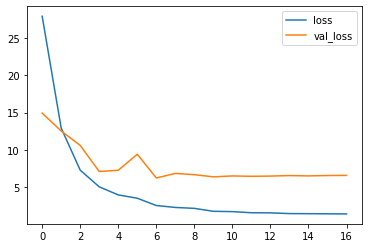

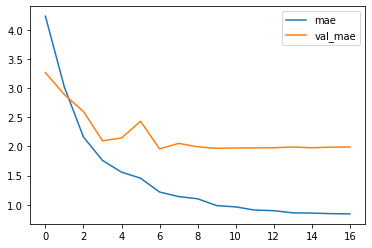

In [18]:
plt.plot(model.history.history["loss"], label="loss");
plt.plot(model.history.history["val_loss"], label="val_loss");
plt.legend();
plt.show();
plt.close();

plt.plot(model.history.history["mae"], label="mae");
plt.plot(model.history.history["val_mae"], label="val_mae");
plt.legend();

## [Use Transfer Learning](https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/)

In [19]:
# load the whole embedding into memory
embeddings_index = dict()

with open("glove/glove.6B.300d.txt") as f:

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [20]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
model=Sequential()

#embedding layer
#model.add(Embedding(size_of_vocabulary,300,input_length=14,trainable=True)) 
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=max_length,trainable=False)) 


#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer
#optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

#Print summary of model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 14, 300)           1739700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 128)           219648    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,967,669
Trainable params: 227,969
Non-trainable params: 1,739,700
_________________________________________________________________
None


In [22]:
history = model.fit(np.array(x_tr_seq),
                    np.array(y_tr),
                    batch_size=128,
                    epochs=50,
                    validation_data=(np.array(x_val_seq),np.array(y_val)),
                    verbose=1,
                    callbacks=callbacks)

Train on 4651 samples, validate on 1164 samples
Epoch 1/50
4651/4651 [==============================] - 2s 423us/step - loss: 21.5913 - mae: 3.6785 - val_loss: 13.4045 - val_mae: 2.9652
Epoch 2/50
4651/4651 [==============================] - 1s 274us/step - loss: 8.1133 - mae: 2.2719 - val_loss: 8.0178 - val_mae: 2.2843
Epoch 3/50
4651/4651 [==============================] - 1s 272us/step - loss: 7.1850 - mae: 2.1321 - val_loss: 7.7248 - val_mae: 2.2386
Epoch 4/50
4651/4651 [==============================] - 1s 277us/step - loss: 6.6344 - mae: 2.0314 - val_loss: 8.3726 - val_mae: 2.2566
Epoch 5/50
4651/4651 [==============================] - 1s 287us/step - loss: 6.1618 - mae: 1.9633 - val_loss: 8.0802 - val_mae: 2.2286
Epoch 6/50
4651/4651 [==============================] - 1s 286us/step - loss: 6.0160 - mae: 1.9171 - val_loss: 7.0459 - val_mae: 2.1340
Epoch 7/50
4651/4651 [==============================] - 1s 281us/step - loss: 5.7767 - mae: 1.8869 - val_loss: 6.5312 - val_mae: 1.998

In [23]:
#evaluation 
_, val_mae = model.evaluate(x_val_seq, y_val)

print("The val_mae is %.3f." % val_mae)

1164/1164 [==============================] - 0s 174us/step
The val_mae is 1.869.


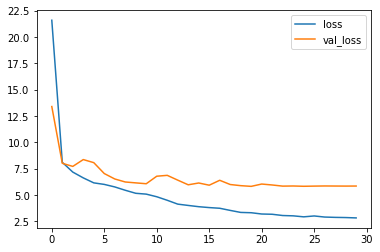

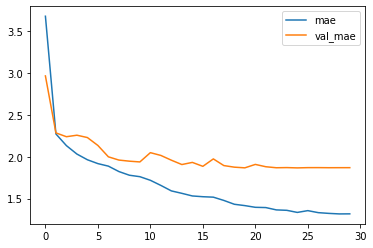

In [24]:
plt.plot(model.history.history["loss"], label="loss");
plt.plot(model.history.history["val_loss"], label="val_loss");
plt.legend();
plt.show();
plt.close();

plt.plot(model.history.history["mae"], label="mae");
plt.plot(model.history.history["val_mae"], label="val_mae");
plt.legend();